# 2M1207b discovery image with NACO (April 2004) -- notebook built mostly by Dimitri Mawet

## Import packages

In [1]:
import numpy as np
from os import mkdir
from os.path import join, sep,exists
import glob
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import stats
from scipy.ndimage.filters import median_filter
from scipy.ndimage.interpolation import shift
%matplotlib inline

## Set up parameters and paths

In [8]:
frameSize = 351
band = 'K'
tg_name= '2M1207'
useRefFrames = False
path_input = './2M1207_bands/2M1207_bands/Kband/'
path_output = path_input + 'out/'
sep='/'
path_flats = path_input+'flats'+sep
path_flats_darks = path_input+'flats/darks'+sep
path_sci = path_input+'sci'+sep
path_darks = path_input+'darks'+sep

## Construct lists of images files and print list

In [9]:
filelist_flats = glob.glob(path_flats+'*.fits')
filelist_flats_darks = glob.glob(path_flats_darks+'*.fits')
filelist_sci = sorted(glob.glob(path_sci+'*.fits'))
filelist_darks = glob.glob(path_darks+'*.fits')

print((filelist_sci))

['./2M1207_bands/2M1207_bands/Kband/sci/NACO.2004-04-27T03_22_55.237.fits', './2M1207_bands/2M1207_bands/Kband/sci/NACO.2004-04-27T03_24_22.128.fits', './2M1207_bands/2M1207_bands/Kband/sci/NACO.2004-04-27T03_25_48.842.fits', './2M1207_bands/2M1207_bands/Kband/sci/NACO.2004-04-27T03_27_16.146.fits', './2M1207_bands/2M1207_bands/Kband/sci/NACO.2004-04-27T04_07_13.357.fits', './2M1207_bands/2M1207_bands/Kband/sci/NACO.2004-04-27T04_08_40.041.fits', './2M1207_bands/2M1207_bands/Kband/sci/NACO.2004-04-27T04_10_07.477.fits', './2M1207_bands/2M1207_bands/Kband/sci/NACO.2004-04-27T04_11_34.166.fits']


## Print out how many files there are of each type

In [10]:
print("Number of flat fields: ",len(filelist_flats))
print("Number of darks for flat fields: ",len(filelist_flats_darks))
print("Number of science images: ",len(filelist_sci))
print("Number of darks for science images: ",len(filelist_darks))

Number of flat fields:  22
Number of darks for flat fields:  3
Number of science images:  8
Number of darks for science images:  3


## Raw image - open one file, crop, and display

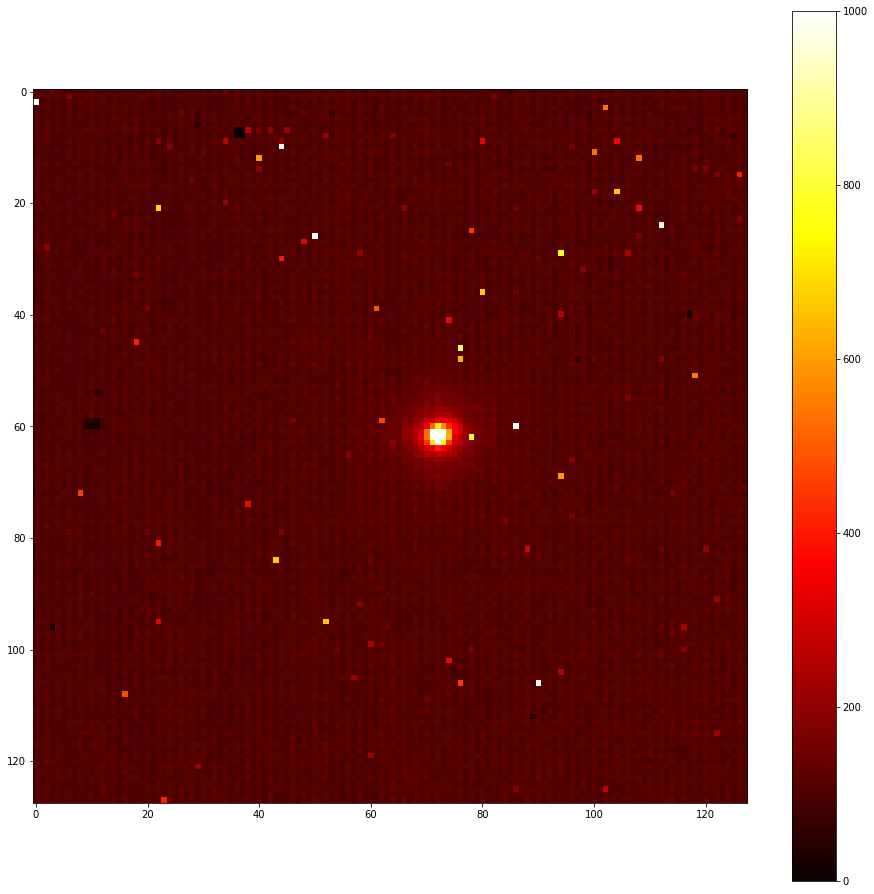

In [11]:
raw_sci = fits.open(filelist_sci[0])[0].data
crop = 128
dimx = raw_sci.shape[0]
dimy = raw_sci.shape[1]
x1 = int((dimx - crop)/2)
x2 = int(x1 + crop)
y1 = int((dimy - crop)/2)
y2 = int(y1 + crop)
raw_sci = shift(raw_sci,[-100,-100])
raw_cropped = raw_sci[x1:x2,y1:y2]
raw_cropped.shape
plt.figure(figsize=(16,16))
#plt.imshow(raw_cropped,vmin=0,vmax=200,cmap='hot') # see image of source
#plt.imshow(raw_cropped,vmin=0,vmax=100,cmap='hot') # see dead pixels and bright sky background
plt.imshow(raw_cropped,vmin=0,vmax=1000,cmap='hot') # see hot pixels
plt.colorbar()

# Master flat and cold/dead pixels

## Read dark files

In [12]:
flats_darks_cube_tmp=[]
for filename in filelist_flats_darks:
    dummy = fits.open(filename)[0].data
    flats_darks_cube_tmp.append(dummy)

## Construct the median dark frame and plot the image

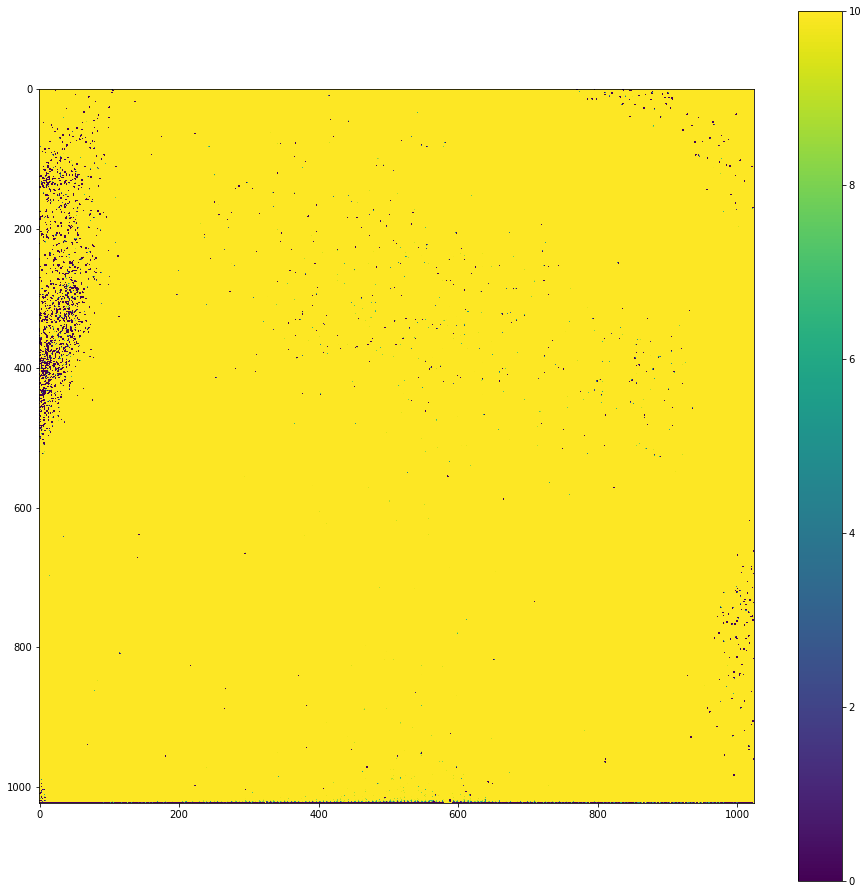

In [13]:
flats_darks_cube = np.array(flats_darks_cube_tmp)
masterflats_darks = np.median(flats_darks_cube,axis=0)
plt.figure(figsize=(16,16))
plt.imshow(masterflats_darks,vmin=0,vmax=10) # show median dark frame
#plt.imshow(masterflats_darks,vmin=0,vmax=100) # shows grid-like structure and extra noise at corners (heat from electronics)
plt.colorbar()

## Read flat images and subtract master dark as we go

In [14]:
flats_cube_tmp=[]
for filename in filelist_flats:
    dummy = fits.open(filename)[0].data-masterflats_darks # subtrack dark frame from each flat
    flats_cube_tmp.append(dummy) # add up all of the flat fields

## Compute the master flat as the median of all flats (22 images) and display

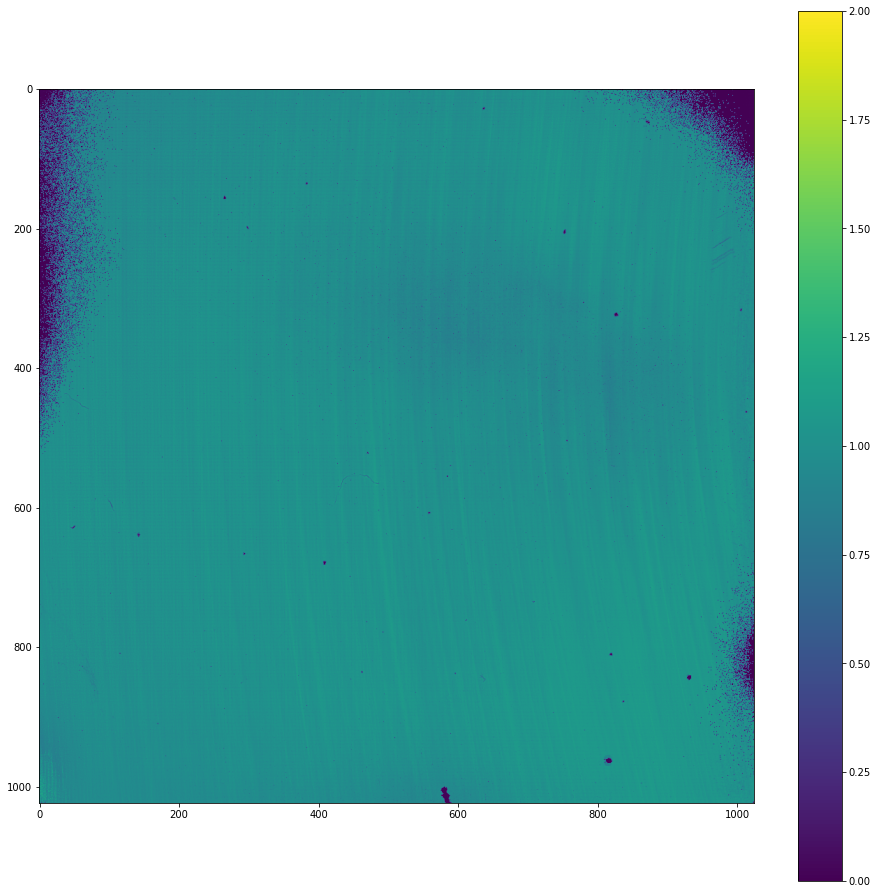

In [15]:
flats_cube = np.array(flats_cube_tmp)
masterflat = np.median(flats_cube,axis=0)
masterflat /= np.median(masterflat)
fits.writeto(path_output+'masterflat.fits',masterflat,overwrite=True)
plt.figure(figsize=(16,16))
plt.imshow(masterflat,vmin=0,vmax=2) # mostly green (near 1.0)
plt.colorbar()

## Construct cold pixel map - identify pixels with response < 70% of other pixels

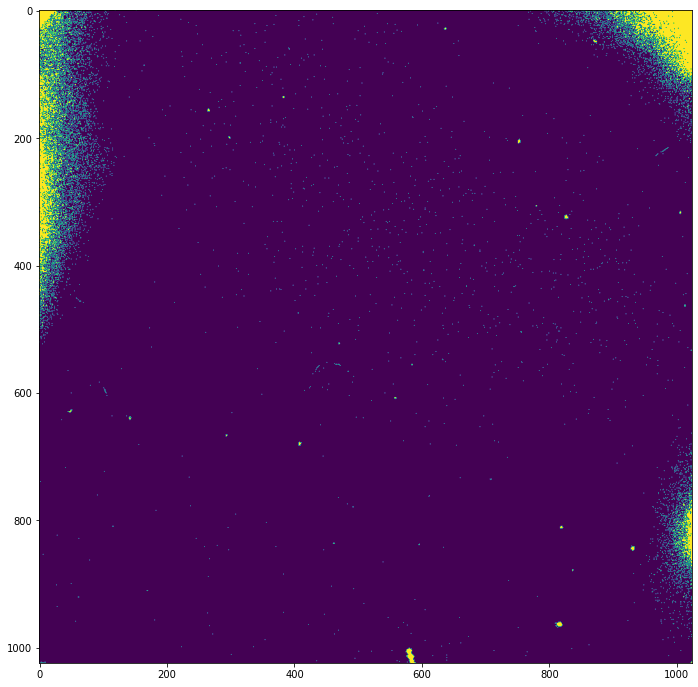

In [16]:
bpmap_cold = masterflat <= 0.7
plt.figure(figsize=(12,12))
plt.imshow(bpmap_cold)
fits.writeto(path_output+'bpmap_cold.fits',1.*bpmap_cold,overwrite=True)

# kernel_size = 10
# median_map = median_filter(masterflat_clipped, kernel_size)

## Construct master dark and note hot pixels

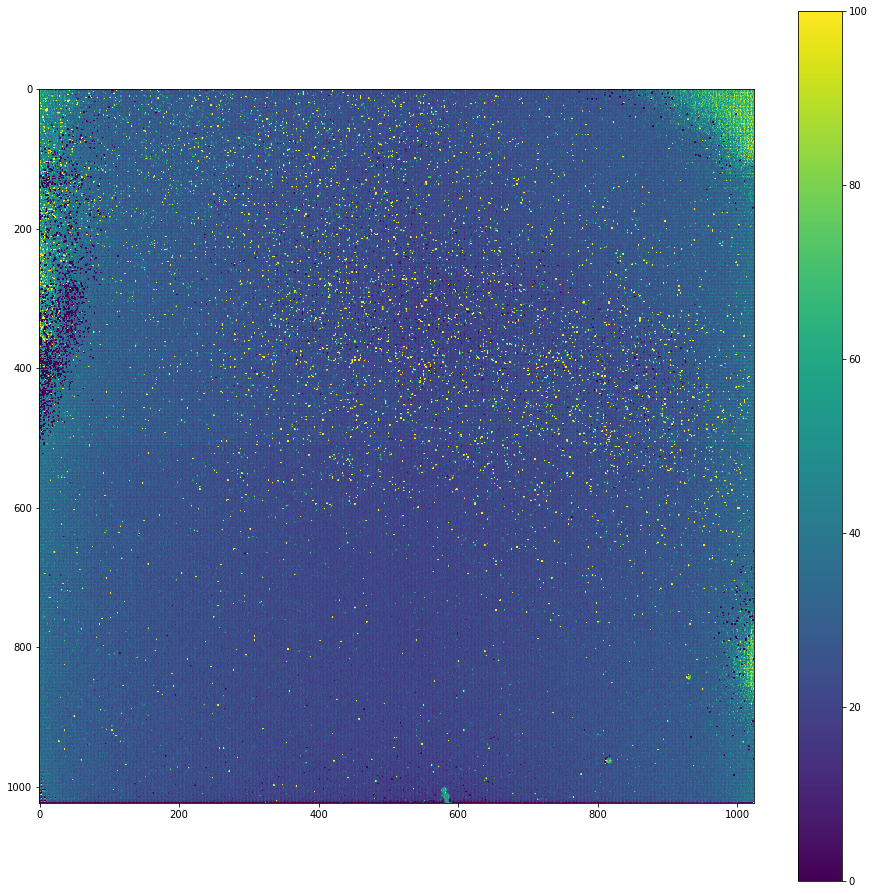

In [17]:
darks_cube_tmp=[]
for filename in filelist_darks:
    dummy = fits.open(filename)[0].data
    darks_cube_tmp.append(dummy)
kernel_size = 10
darks_cube = np.array(darks_cube_tmp)
masterdark = np.median(darks_cube,axis=0)
masterdark_median = median_filter(masterdark, kernel_size)
fits.writeto(path_output+'masterdark.fits',masterdark,overwrite=True)
plt.figure(figsize=(16,16))
#plt.imshow(masterdark,vmin=0,vmax=10) # show median of dark frames
plt.imshow(masterdark,vmin=0,vmax=100) # can see hot pixels if we change the color bar
plt.colorbar()

## Identify the hot pixels (have dark > 5X median(smoothed(dark)) and make hot pixel map

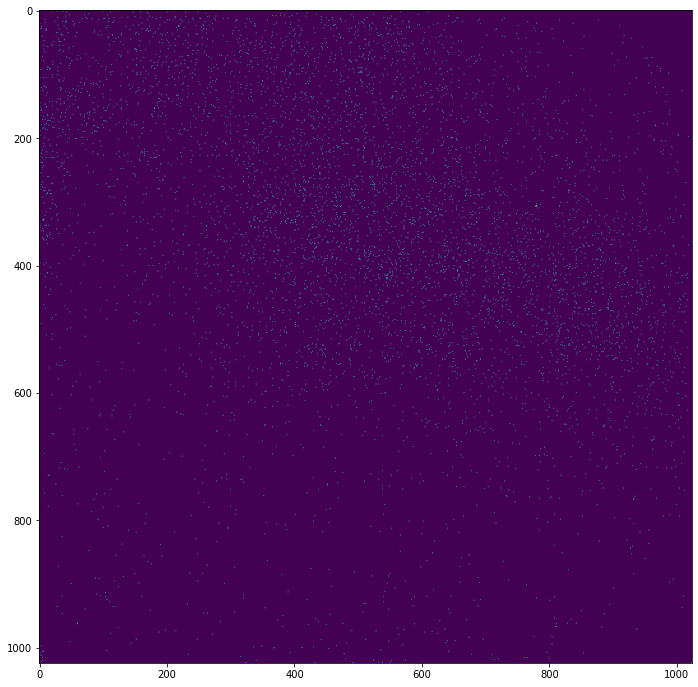

In [18]:
bpmap_hot = masterdark > 5*masterdark_median
plt.figure(figsize=(12,12))
fits.writeto(path_output+'bpmap_hot.fits',1.*bpmap_hot,overwrite=True)
plt.imshow(bpmap_hot)
# kernel_size = 10
# median_map = median_filter(masterflat_clipped, kernel_size)

## Construct the bad pixel map that accounts for cold pixels and hot pixels

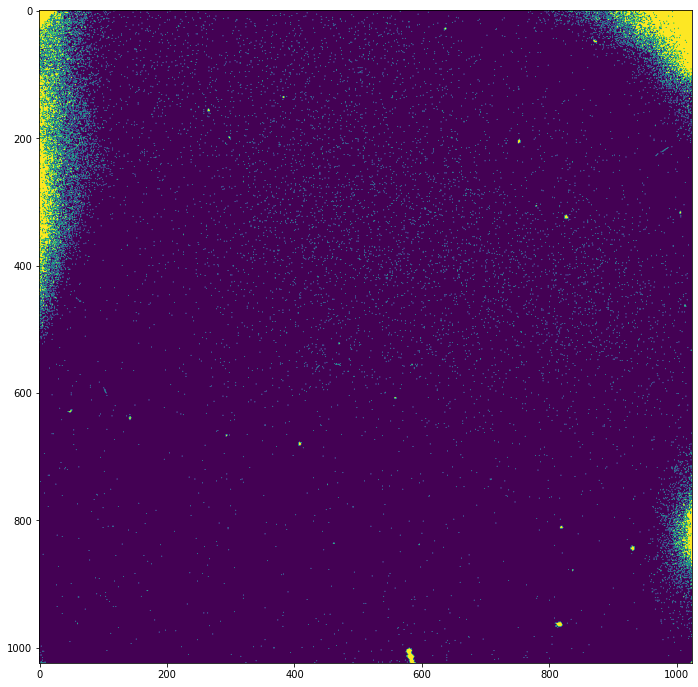

In [19]:
bpmap = bpmap_cold + bpmap_hot
plt.figure(figsize=(12,12))
plt.imshow(bpmap)
fits.writeto(path_output+'bpmap.fits',1.*bpmap,overwrite=True)

# Science data

## Read array of FITS files

In [20]:
sci_cube_tmp=[]
sci_header_tmp=[]
shiftx_tmp=[]
shifty_tmp=[]
for filename in filelist_sci:
    hdu = fits.open(filename)[0]
    sci_header_tmp.append(hdu.header) # read headers including pointing offsets
    data = hdu.data
    data -= masterdark   # PROCESSING STEP - subtract master dark image
    data /= masterflat   # PROCESSING STEP - divide by master flat image
    sci_cube_tmp.append(data)
    shiftx_tmp.append(hdu.header['HIERARCH ESO SEQ CUMOFFSETX'])
    shifty_tmp.append(hdu.header['HIERARCH ESO SEQ CUMOFFSETY'])
    

/Users/jakobfaber/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/jakobfaber/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


## Compute the sky image from a series of dithered images of the source.
## The sky image is the median of the dithered stack.
## The "sky" can include other sources of emissivity, e.g. from the telescope.

/Users/jakobfaber/.pyenv/versions/3.7.3/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


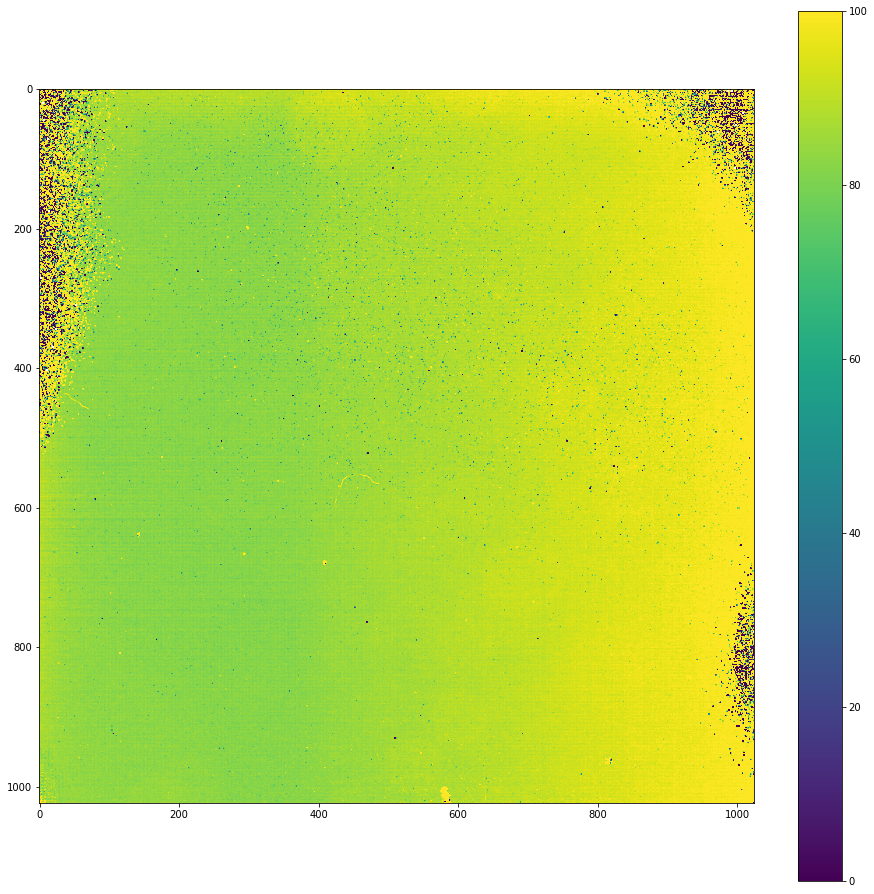

In [21]:
# for a series of dithered images of the source, the median of the stack is the sky image
# the sky can include other sources of emissivity, e.g. from the telescope
sci_cube = np.array(sci_cube_tmp)
sky = np.median(sci_cube,axis=0)
plt.figure(figsize=(16,16))
plt.imshow(sky,vmin=0,vmax=100)
plt.colorbar()

## Subtract sky background from the science frames and replace bad pixels

/Users/jakobfaber/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


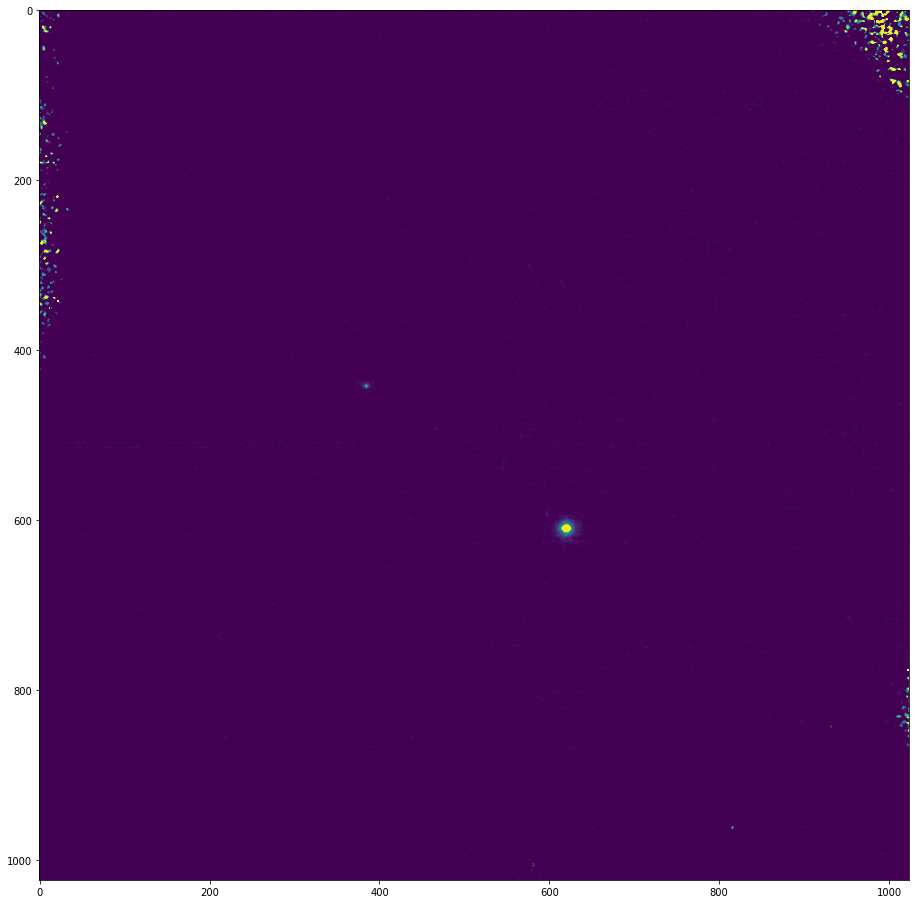

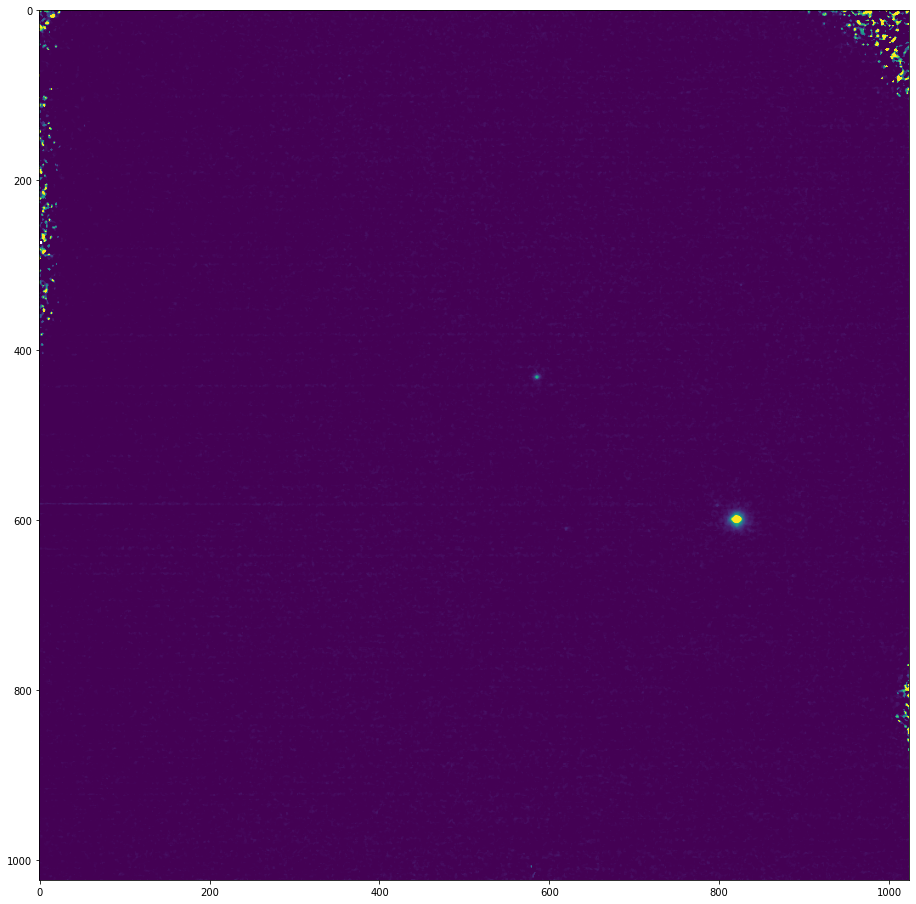

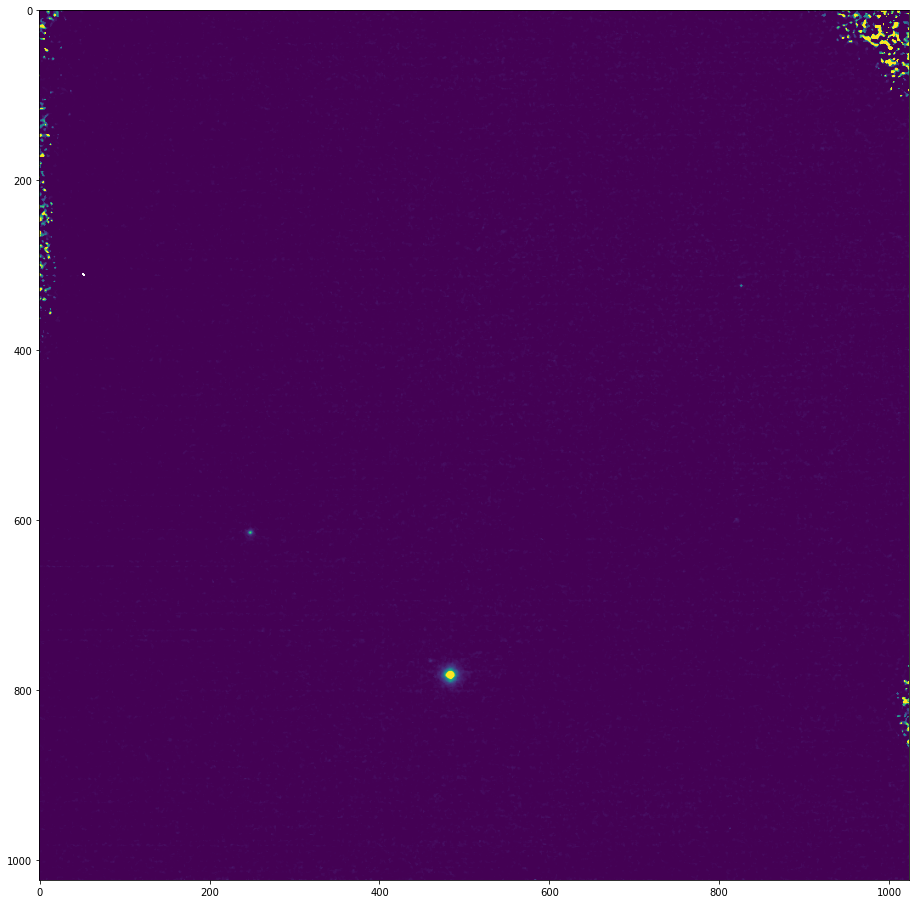

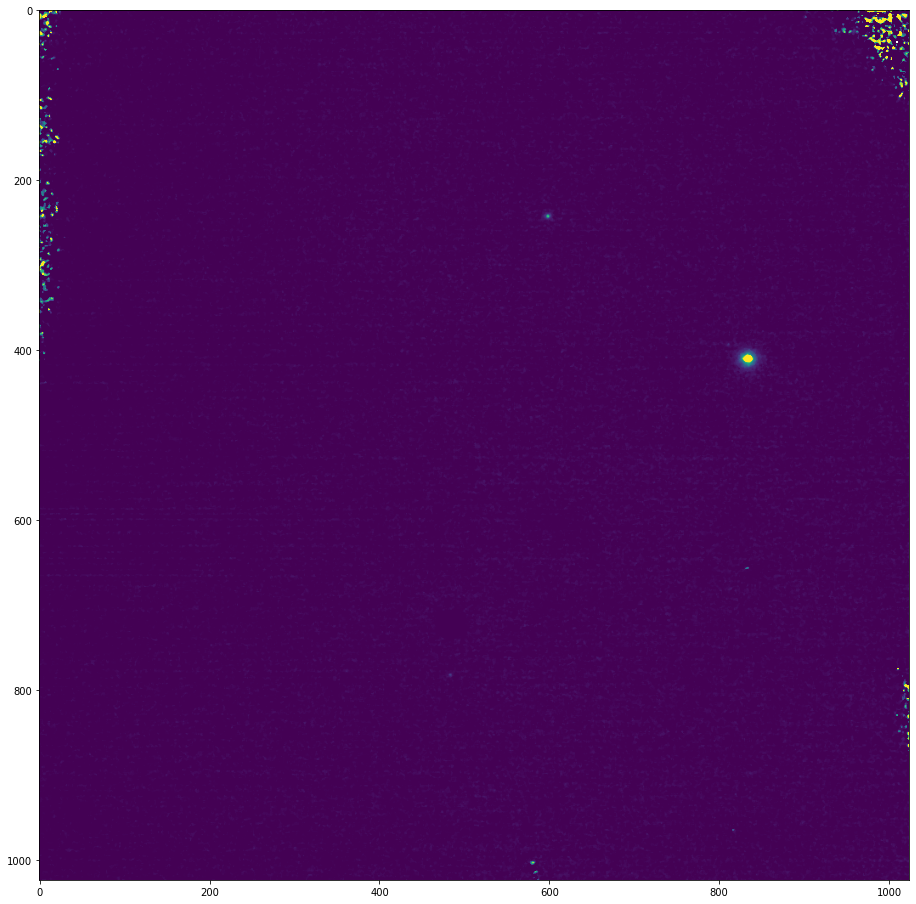

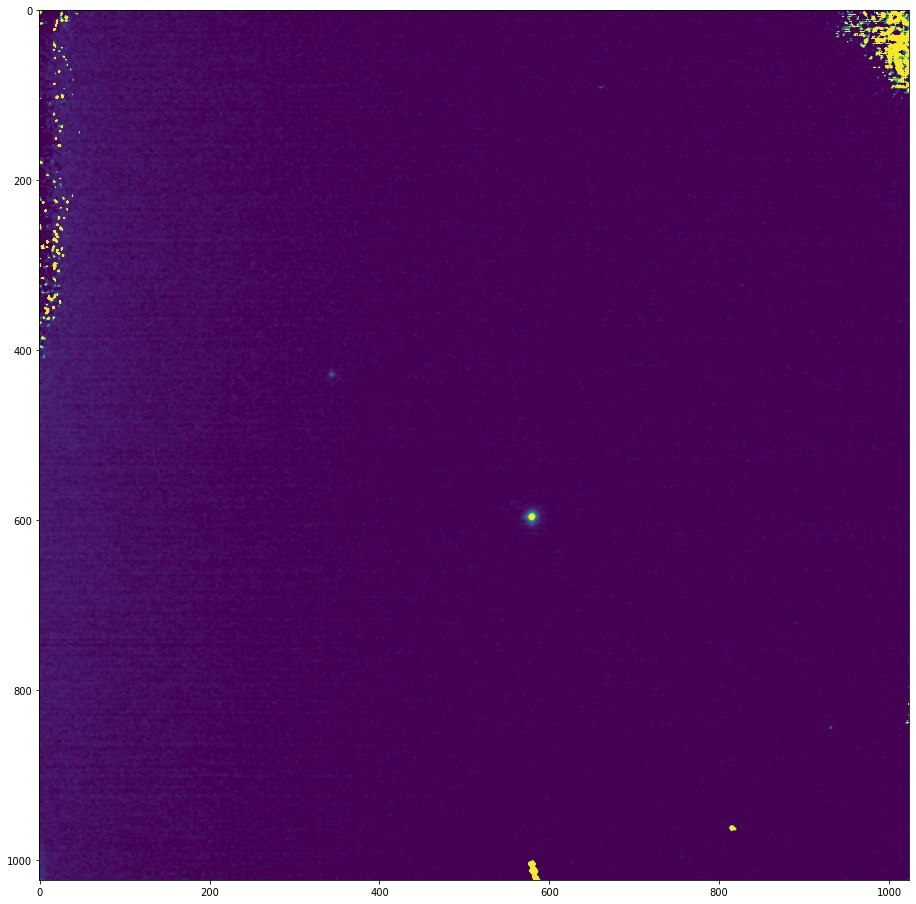

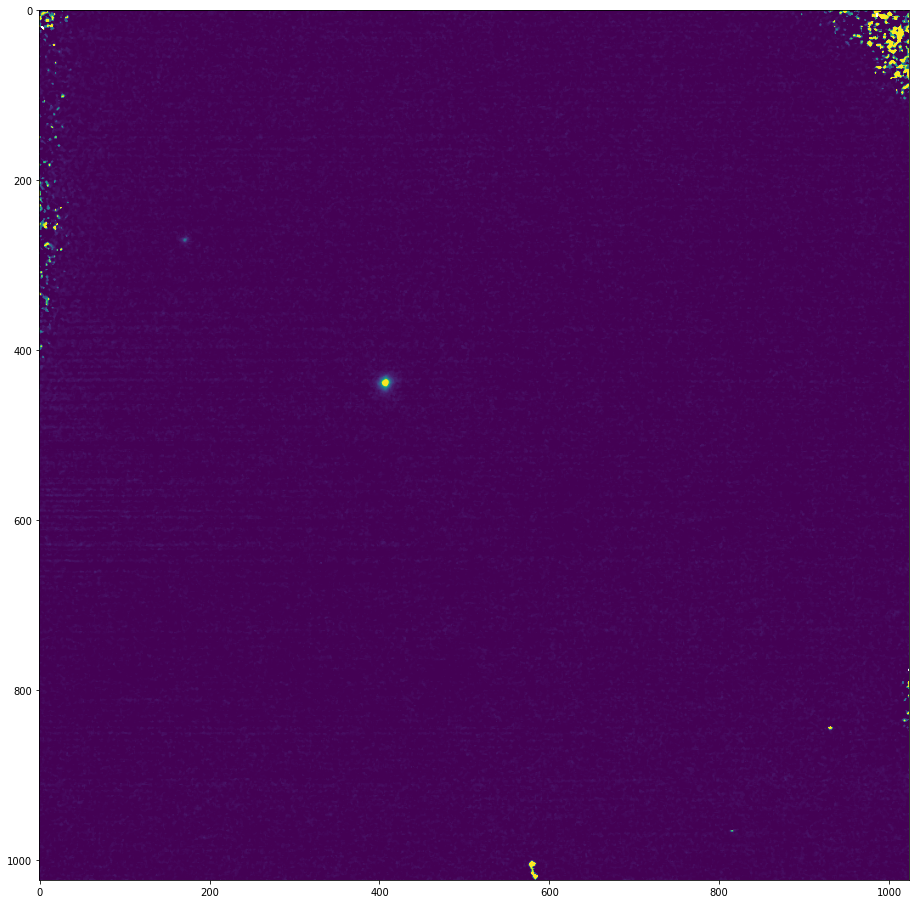

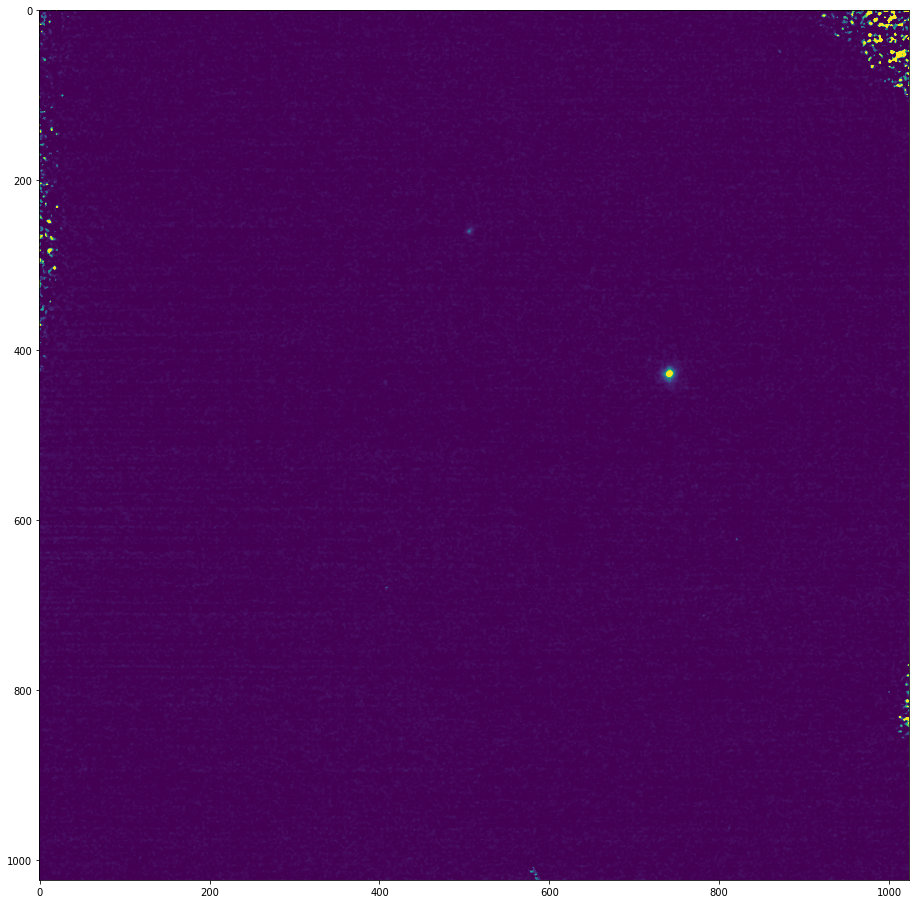

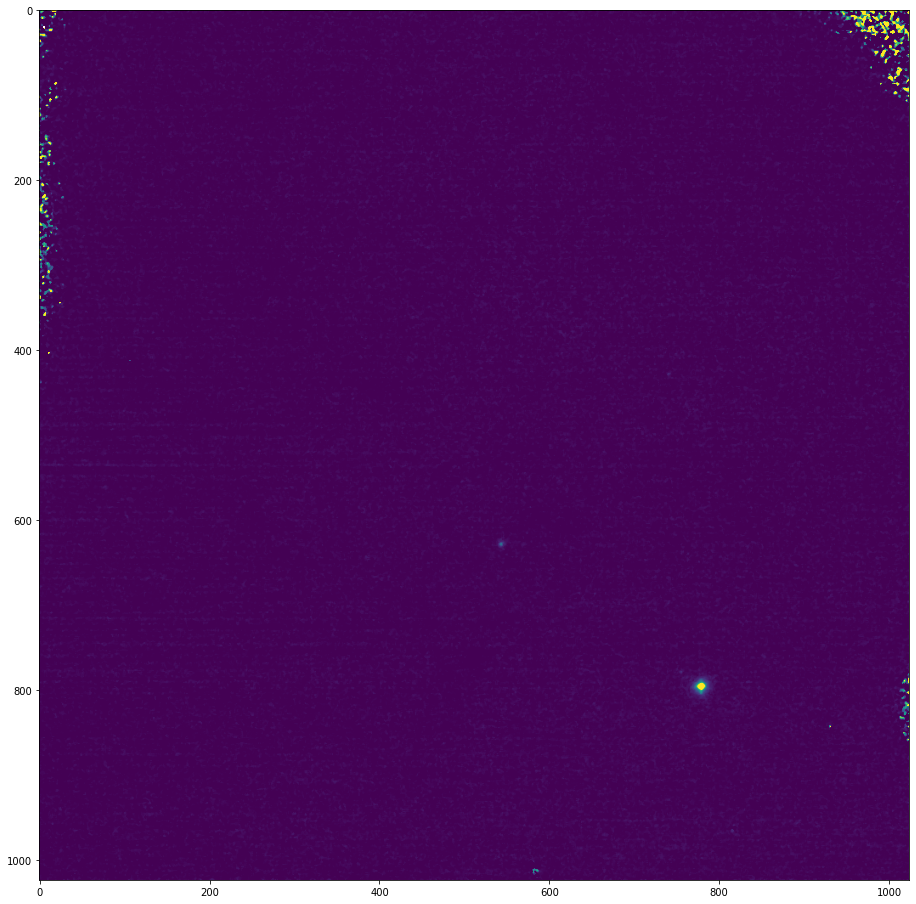

In [22]:
kernel_size = 3
for i in range(sci_cube.shape[0]):
    dummy = sci_cube[i,:,:]
    dummy -= sky
    dummy_median = median_filter(dummy,kernel_size)
    dummy[np.where(bpmap == True)]=dummy_median[np.where(bpmap == True)] # replace bad pixels from median of local pix
    sci_cube[i,:,:] = median_filter(dummy,kernel_size)
    plt.figure(figsize=(16,16)) # note clean images!
    plt.imshow(dummy,vmin=0,vmax=100)

## Save science frame cube

In [23]:
fits.writeto(path_output+'test.fits',sci_cube,overwrite=True)

## Crop science image to remove edges

In [24]:
sci_cube.shape

(8, 1024, 1024)

In [25]:
crop = 768
dimx = sci_cube.shape[1]
dimy = sci_cube.shape[2]
x1 = int((sci_cube.shape[1] - crop)/2)
x2 = int(x1 + crop)
y1 = int((sci_cube.shape[2] - crop)/2)
y2 = int(y1 + crop)
sci_cube_cropped = sci_cube[:,x1:x2,y1:y2]
sci_cube_cropped.shape

(8, 768, 768)

## Register frames based on header information on offsets

In [26]:
sci_cube_shifted = np.copy(sci_cube_cropped)
for i in range(8):
    dummy = sci_cube_cropped[i,:,:]
    print(shiftx_tmp[i],shifty_tmp[i])
    sci_cube_shifted[i,:,:] = shift(dummy,[-shifty_tmp[i],-shiftx_tmp[i]], order=1)

0.0 0.0
197.0 -10.0
-134.0 170.0
210.0 -197.0
0.0 0.0
-169.0 -156.0
159.0 -166.0
196.0 198.0


## Precise registration based on maximum

In [27]:
sci_cube_shiftedb = np.copy(sci_cube_shifted)

cx=int(crop/2)
cy=int(crop/2)
for i in range(8):
    dummy = sci_cube_shiftedb[i,:,:]
    max_coord = np.unravel_index(np.argmax(dummy, axis=None), dummy.shape)
    print(np.unravel_index(np.argmax(dummy, axis=None), dummy.shape))
    shiftx = cx-max_coord[0]
    shifty = cy-max_coord[1]
    print(shiftx,shifty)
    sci_cube_shiftedb[i,:,:] = shift(dummy,[shiftx,shifty], order=1)

(481, 492)
-97 -108
(481, 495)
-97 -111
(484, 489)
-100 -105
(479, 496)
-95 -112
(468, 451)
-84 -67
(466, 448)
-82 -64
(466, 454)
-82 -70
(469, 455)
-85 -71


In [28]:
final_image = np.median(sci_cube_shiftedb[0:3,:,:],axis=0)
fits.writeto(path_output+'test2.fits',sci_cube_shiftedb,overwrite=True)

In [29]:
fits.writeto(path_output+'final_image.fits',final_image,overwrite=True)

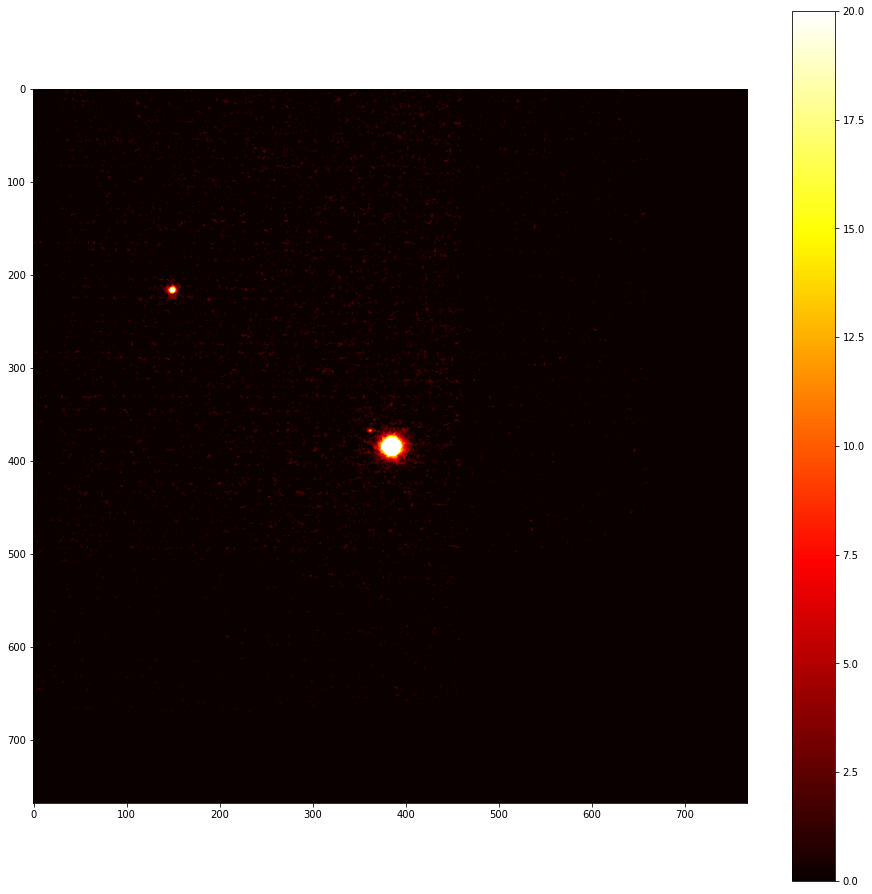

In [63]:
plt.figure(figsize=(16,16))
plt.imshow(final_image,vmin=0,vmax=20,cmap='hot')
plt.colorbar()

## Zoom in on final image and plot

In [30]:
crop = 128
dimx = final_image.shape[0]
dimy = final_image.shape[1]
x1 = int((dimx - crop)/2)
x2 = int(x1 + crop)
y1 = int((dimy - crop)/2)
y2 = int(y1 + crop)
final_image_cropped = final_image[x1:x2,y1:y2]
final_image_cropped.shape

(128, 128)

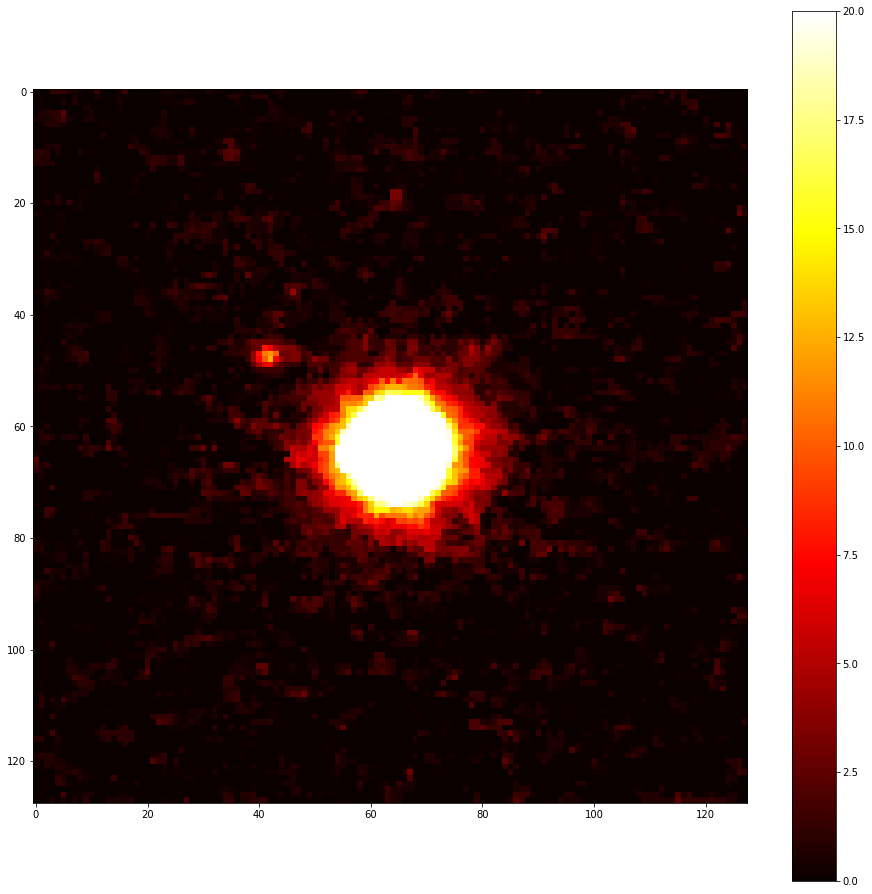

In [31]:
plt.figure(figsize=(16,16))
plt.imshow(final_image_cropped,vmin=0,vmax=20,cmap='hot')
plt.colorbar()

## Find sources in the image

In [32]:
from photutils import DAOStarFinder
from astropy.stats import mad_std
bkg_sigma = mad_std(final_image_cropped)
daofind = DAOStarFinder(fwhm=4.,threshold=12.*bkg_sigma)  # use 12x background_sigma
sources = daofind(final_image_cropped)  ## find sources in image
for col in sources.colnames:
    sources[col].info.format = '%.8g' # formatting trick for consistent table output
print(sources)

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
  1 41.642084 47.436662 0.41084982 ...   0 11.696487 1.2743709 -0.26323964
  2 64.568959 64.108465 0.43041323 ...   0 1030.5647 111.48983  -5.1180881
  3 64.794873 71.696963 0.56676358 ...   0 47.159164 1.4867499 -0.43059481


## Do aperture photometry on sources

In [61]:
from photutils import aperture_photometry, CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)
phot_table = aperture_photometry(final_image_cropped, apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)
print('\n')
print(f"Brown Dwarf Aperture Sum: {phot_table['aperture_sum'][1]}")
print(f"Planet Aperture Sum: {phot_table['aperture_sum'][0]}")

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 41.642084 47.436662    192.28016
  2 64.568959 64.108465    16725.869
  3 64.794873 71.696963    2055.6349


Brown Dwarf Aperture Sum: 16725.868863984033
Planet Aperture Sum: 192.28016296389913


## Highlight the sources found

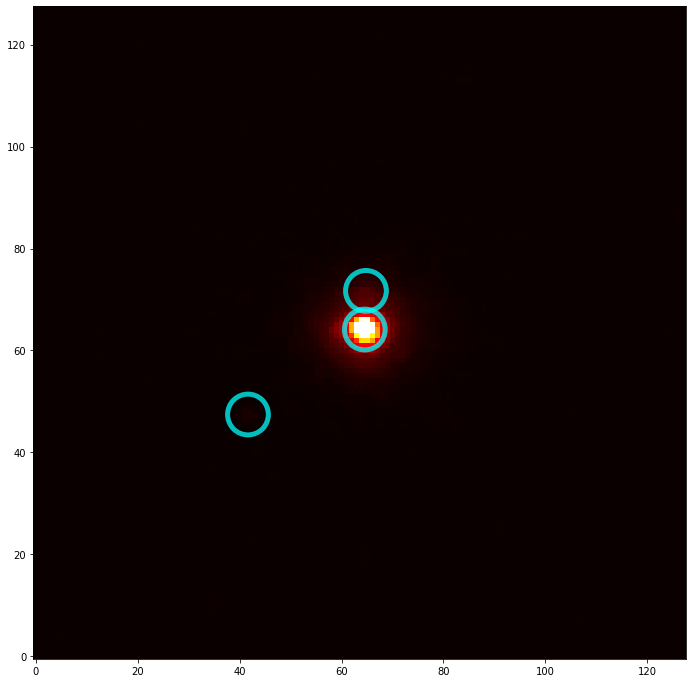

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.imshow(final_image_cropped,vmin=0,vmax=500,cmap='hot',origin='lower')
apertures.plot(color='cyan',lw=5,alpha=0.75)

## Compute flux ratio

In [58]:
#flux_ratio = 16725.869 / 192.28016
flux_ratio = phot_table['aperture_sum'][1] / phot_table['aperture_sum'][0]
print(flux_ratio)

86.98697050264275


## Compute magnitude difference

In [59]:
mag_difference = 2.5*np.log10(flux_ratio)
print(mag_difference)

4.8486355148058085


## On the Simbad website, 2M1207 (the brown dwarf) has K = 11.9 mag
## Compute the planet's brightness in K-band magnitude

In [60]:
k_mag_brown_dwarf = 11.945
k_mag_planet = k_mag_brown_dwarf + mag_difference
print(k_mag_planet)

16.793635514805807


In [ ]:
# separation can be determined knowing the pixel scale (13 milliarcseconds/pixel)